In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Load the CIFAR-10 data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # normalize from 0.0 to 1.0
y_train, y_test = y_train.flatten(), y_test.flatten()

In [3]:
class LossPerClassCallback(Callback):
  def __init__(self, x, y, loss_fn):
    """Callback class to acccumulate the loss per class per epoch.

    Args:
      x (np.ndarray): input data
      y (np.ndarray): labels in raw format
    """
    self.x = x
    self.y = y
    self.loss_fn = loss_fn

    # only the classes present in the test set
    self.classes = set(self.y)

    # for each class an array of indexes in x_test and y_test
    # that correspond to that class
    self.indexes_per_class = {
        cls: np.where(self.y == cls)[0] for cls in self.classes
    }

    # empty dictionary logging the loss in each epoch for each class
    self.loss_per_class_per_epoch = {cls: [] for cls in self.classes}
    self.total_loss_per_epoch = []
    self.num_epochs = 0
  
  def on_epoch_end(self, epoch, logs={}):
    self.num_epochs += 1
    for cls in self.classes:
      cls_indexes = self.indexes_per_class[cls]
      x_cls, y_cls = self.x[cls_indexes], self.y[cls_indexes]
      y_pred_cls = self.model.predict(x_cls)
      loss = self.loss_fn(y_cls, y_pred_cls)
      self.loss_per_class_per_epoch[cls].append(loss)

    y_pred = self.model.predict(self.x)
    loss = self.loss_fn(self.y, y_pred)
    self.total_loss_per_epoch.append(loss)


  def plot_losses(self):
    """Helper method to plot the loss per class per epoch"""
    fig = plt.figure(figsize=(21, 10))
    ax = plt.axes(xlim=(0, self.num_epochs + 1))
    ax.set_xticks(np.arange(0, self.num_epochs, 5))
    ax.set_title('Loss per class per epoch', fontsize=22)
    ax.set_xlabel('Epoch', fontsize=18)
    ax.set_ylabel('Loss', fontsize=18)
    ax.tick_params(labelsize=16)
    ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)
    
    for cls in self.classes:
      ax.plot(
        np.arange(0, self.num_epochs), 
        self.loss_per_class_per_epoch[cls],
        label=f"class {cls}",
        linestyle='-.',
      )

    ax.plot(
      np.arange(0, self.num_epochs),
      self.total_loss_per_epoch,
      label="total loss",
      linewidth=3,
      color="k",
    )

    ax.legend()
    plt.savefig('loss_per_class.png', bbox_inches='tight')

In [4]:
num_classes = len(set(y_train))

In [5]:
def make_model():
  """Build a simple neural network using the Sequential API"""
  model = Sequential([
      Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(32, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Conv2D(64, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding='same'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Flatten(),
      Dropout(0.2),
      Dense(1024, activation='relu'),
      Dropout(0.2),
      Dense(num_classes, activation='softmax'),
    ])
  
  model.compile(
      optimizer='adam',
      loss=SparseCategoricalCrossentropy(),
      metrics=['accuracy'],
  )

  return model

In [6]:
model = make_model()

In [7]:
# subsampled data for the callback
_, x_train_sample, _, y_train_sample = train_test_split(
  x_train,
  y_train,
  stratify=y_train, 
  test_size=0.25,
)

loss_per_class_callback = LossPerClassCallback(
  x_train_sample,
  y_train_sample,
  model.loss,
)

In [ ]:
model.fit(
  x_train,
  y_train,
  validation_data=(x_test, y_test), 
  epochs=50,
  verbose=0,
  callbacks=[loss_per_class_callback],
)

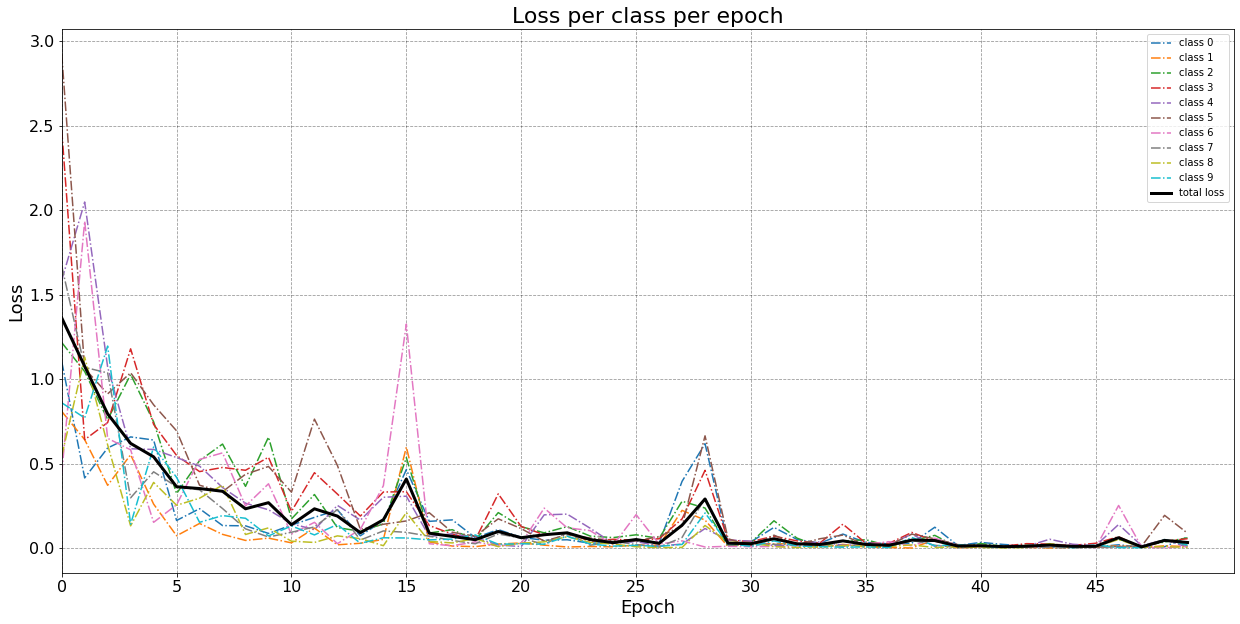

In [9]:
loss_per_class_callback.plot_losses()

In [10]:
class_3_image_index = np.where(y_train == 3)[0][1]
class_3_image = x_train[class_3_image_index]

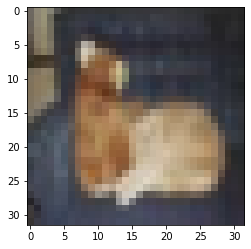

In [11]:
plt.imshow(class_3_image)

In [12]:
class_1_image_index = np.where(y_train == 1)[0][1]
class_1_image = x_train[class_1_image_index]

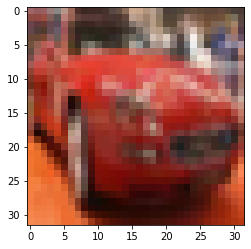

In [13]:
plt.imshow(class_1_image)